# A Random Forest from Scratch

As per fast.ai ML for Coders 2018 course, lesons 6 & 7.

The body of Jeremy's solution can be found in lesson3-rf_foundations.ipynb.

&copy; Richard Guinness August 2022

## Preliminaries

In [1]:
import json, re, sys, os

import matplotlib.pyplot as plt, seaborn as sb
import math
import numpy as np, pandas as pd
#import requests
import graphviz # conda install python-graphviz

import scipy
from scipy.cluster import hierarchy as hc

from IPython.display import clear_output

from sklearn import tree, metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings

sb.set(rc={"figure.dpi": 78, "savefig.dpi": 78, "figure.figsize":(10,6)})
sb.set(rc={})
sb.set_context("notebook")
sb.set_style("ticks")
sb.set_style("darkgrid")  # Make it pretty!
base_color = sb.color_palette()[0]

# Ensure we see all columns, and the contents of each!
#pd.set_option("display.max_colwidth", None)
#pd.set_option("display.max_columns", None)

np.set_printoptions(linewidth=130)

%matplotlib inline
# %config InlineBackend.figure_format = 'retina' # Increase resolution of plots. Seems to conflict with seaborn settings above

# automatically reloads imports
%load_ext autoreload
%autoreload 2

DATA_PATH = 'data'

print(f"sys.version: {sys.version}")
print(f"pd.__version__: {pd.__version__}")

sys.version: 3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]
pd.__version__: 1.4.2


### Read Titanic data from disk

In [2]:
df_train = pd.read_feather(os.path.join(DATA_PATH, 'df_train.feather'))
df_valid = pd.read_feather(os.path.join(DATA_PATH, 'df_valid.feather'))

df_train = df_train.set_index('PassengerId')
df_valid = df_valid.set_index('PassengerId')

In [3]:
X_train = df_train.drop('survived',axis=1) #[['age']]
y_train = df_train['survived'].values # convert to an ndarray
X_valid = df_valid.drop('survived',axis=1)
y_valid = df_valid['survived']

In [4]:
X_train

,pclass,is_male,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,
1,0,1,22.0,1,0,523,7.2500,147,2
2,2,0,38.0,1,0,596,71.2833,81,0
3,0,0,26.0,0,0,669,7.9250,147,2
4,2,0,35.0,1,0,49,53.1000,55,2
5,0,1,35.0,0,0,472,8.0500,147,2
...,...,...,...,...,...,...,...,...,...
709,2,0,22.0,0,0,37,151.5500,147,2
710,0,1,0.0,1,1,189,15.2458,147,0
711,2,0,24.0,0,0,582,49.5042,84,0


In [5]:
y_train[:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

### Define Test function

In [6]:
def test_ens(test_ens):
    return str([[test_ens.trees[i] for i in range(10)], test_ens.trees[0], test_ens.trees[0].rhs, test_ens.trees[0].rhs.rhs, test_ens.trees[0].rhs.rhs.rhs, test_ens.trees[0].lhs, test_ens.trees[0].lhs.rhs, test_ens.trees[0].lhs.lhs])

## Jeremy's Solution

In [7]:
class TreeEnsembleJ():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTreeJ(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [8]:
class DecisionTreeJ():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTreeJ(self.x, self.y, self.idxs[lhs])#, self.min_leaf)
        self.rhs = DecisionTreeJ(self.x, self.y, self.idxs[rhs])#, self.min_leaf)

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi
                
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [9]:
ensJ = TreeEnsembleJ(X_train, y_train, 10, sample_sz=200, min_leaf=5)

In [10]:
predsJ = ensJ.predict(X_valid.values)
predsJ[:10]

array([0.29571429, 0.09095238, 0.        , 0.9       , 0.76190476, 0.        , 0.05333333, 0.88380952, 0.        , 0.35587302])

## My Effort #1

In [11]:
class TreeEnsembleM():

    def __init__(self, x, y, n_trees, sample_sz=None, min_leaf=5):
        np.random.seed(42)
        self.x, self.y = x, y
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        
        if self.sample_sz:
            idx_sub = np.random.permutation(len(self.y))[:self.sample_sz] # Create an index of random subsamples

            tree = DecisionTreeM(
                x=self.x.iloc[idx_sub], y=self.y[idx_sub], # select subsamples by integer location
                idxs=np.arange(self.sample_sz), # we don't want to track the rows - we're only interested in values
                min_leaf=self.min_leaf
                )
        else:
            tree = DecisionTreeM(
                x=self.x, y=self.y,
                idxs=np.arange(len(self.y)),
                min_leaf=self.min_leaf
                )
        
        return tree
    
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [12]:
class DecisionTreeM():
    
    def __init__(self, x, y, idxs, min_leaf=5):
        self.min_leaf = min_leaf
        self.idxs = idxs
        self.x, self.y = x, y
        self.n = len(self.idxs)
        self.c = x.shape[1]
        self.val = np.mean(y[self.idxs])
        self.score = float('inf')
        
        self.find_varsplit()
    
    def find_varsplit(self):
        for c in range(self.c):
            self.find_better_split(c)
        if self.score == float('inf'): # We're working with a leaf
            return
        
        x = self.x.values[self.idxs,self.var_idx]
        
        m_left = self.m_left # m_left = np.nonzero(x<=self.split)[0]
        m_right = self.m_right # m_right = np.nonzero(x>self.split)[0]
        
        self.lhs = DecisionTreeM(self.x.iloc[m_left],
                                self.y[m_left],
                                np.arange(len(m_left)),
                                min_leaf = self.min_leaf
                               )
        
        self.rhs = DecisionTreeM(self.x.iloc[m_right],
                                self.y[m_right],
                                np.arange(len(m_right)),
                                min_leaf = self.min_leaf
                               )

    def find_better_split(self, var_idx):
        
        x = self.x.iloc[:,var_idx].values
        y = self.y

        poss_values = np.unique(x) # Identify unique values, and return in sorted order
        
        for val_split in poss_values:

            m_left  = x <= val_split
            m_right = x >  val_split

            if m_right.sum() == 0: # no other vals found larger than smallest val, so not a good split. Move on to next var_idx
                return
            
            if m_left.sum() <= self.min_leaf or m_right.sum() <= self.min_leaf: # we've found a leaf
                continue

            left_std,  right_std  = y[m_left].std(), y[m_right].std()

            weighted_std = left_std * m_left.sum() + right_std * m_right.sum() # sum() of bool is analogous to a count

            if weighted_std < self.score:
                self.score = weighted_std
                self.split = val_split
                self.var_idx = var_idx
                self.m_left = np.nonzero(m_left)[0]
                self.m_right = np.nonzero(m_right)[0]
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.score == float('inf'):
            s += f'; score:{self.score}; split:{self.split}; var:{self.x.columns[self.var_idx]}'
        else:
            s += ' (leaf)'
        return s
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [13]:
ensM = TreeEnsembleM(X_train, y_train, 10, sample_sz=200, min_leaf=5)
predsM = ensM.predict(X_valid.values)
predsM[:10] # NOTE: We've taken a slice of values

array([0.25619048, 0.05095238, 0.        , 0.95606061, 0.8000974 , 0.        , 0.07838384, 0.83492063, 0.        , 0.36852814])

Jeremy's solution (when using the exact same parameters) produces the following results.

    array([0.29571429, 0.09095238, 0., 0.9, 0.76190476, 0., 0.05333333, 0.88380952, 0., 0.35587302])
       
What's causing this difference?

Also, I noticed that Jeremy's code doesn't pass min_leaf on to new nodes, but this issue is circumvented because I have specified `min_leaf` 5 (during these tests) which is the default of a new DecisionTree object.

By transplanting my function definitions into Jeremy's body of code, I established the following:

__Importance of slicing x & y with an appropriate index__

Instead of copying x & y (which are quite large variables) during the creation of each node, we should instead simply collate a list of indices relevant to each node. In my original code, I pass the whole lot to each node on instantiation. A left/right mask is created all over again on the whole lot, and this in some instances results in a recursion depth error.

To avoid this eventuality, I needed to update my declaration of x & y within `find_better_split()` as follows:

From:

    x = self.x.iloc[:,var_idx].values
    y = self.y
    
to:

    x = self.x.iloc[self.idxs,var_idx].values
    y = self.y[self.idxs]

I also established that there were some issues in the rest of my `find_better_split()` algorithm.

    if m_left.sum() <= self.min_leaf or m_right.sum() <= self.min_leaf: # We've found a leaf
        continue

The following modifications were necessary:


    if m_left.sum() < self.min_leaf or m_right.sum() < self.min_leaf: # We've found a leaf
        continue

However, I'm not clear that this change is correct. Surely we want to interrupt this loop if we find a group equal in size to `min_leaf`? This could be investigated by comparing each models results with say SKlearn's implementation...

## Findings/Takeaways

1. Realised that transplanting functions between Jeremy & my versions was possible. Each function should achieve the same effect.
2. Realised that comparing the performance of one function with another would be informative (see "Testing `find_better_split()` below". This proved quite cumbersome to do: I literally copy and pasted the function body to a new cell, synthesised a data set, established new variables, and eventually this lead to the discovery that the `m_left.sum() <= self.min_leaf` was responsible for a fishy outcome. However, while I established a solution in this exercise, when implemented in the main program the goal wasn't achieved... this leads me to believe that Jeremy's handling of `min_leaf` probably needs a little exploration.

## My Effort #2

In [14]:
class TreeEnsembleM2():

    def __init__(self, x, y, n_trees, sample_sz=None, min_leaf=5):
        np.random.seed(42)
        self.x, self.y = x, y
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        
        if self.sample_sz:
            idx_sub = np.random.permutation(len(self.y))[:self.sample_sz] # Create an index of random subsamples

            tree = DecisionTreeM2(
                x=self.x.iloc[idx_sub], y=self.y[idx_sub], # select subsamples by integer location
                idxs=np.arange(self.sample_sz), # we don't want to track the rows - we're only interested in values
                min_leaf=self.min_leaf
                )
        else:
            tree = DecisionTreeM2(
                x=self.x, y=self.y,
                idxs=np.arange(len(self.y)),
                min_leaf=self.min_leaf
                )
        
        return tree
    
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [15]:
class DecisionTreeM2():
    
    def __init__(self, x, y, idxs, min_leaf=5):
        self.min_leaf = min_leaf
        self.idxs = idxs
        self.x, self.y = x, y
        self.n = len(self.idxs)
        self.c = x.shape[1]
        self.val = np.mean(y[self.idxs])
        self.score = float('inf')
        
        self.find_varsplit()
    
    def find_varsplit(self):
        for c in range(self.c):
            self.find_better_split(c)
        if self.score == float('inf'): # We're working with a leaf
            return
        
        x = self.x.values[self.idxs,self.var_idx]
        
        m_left = self.m_left # m_left = np.nonzero(x<=self.split)[0]
        m_right = self.m_right # m_right = np.nonzero(x>self.split)[0]
        
        self.lhs = DecisionTreeM2(self.x.iloc[m_left],
                                self.y[m_left],
                                np.arange(len(m_left)),
                                min_leaf = self.min_leaf
                               )
        
        self.rhs = DecisionTreeM2(self.x.iloc[m_right],
                                self.y[m_right],
                                np.arange(len(m_right)),
                                min_leaf = self.min_leaf
                               )

    def find_better_split(self, var_idx):
        
        x = self.x.iloc[self.idxs,var_idx].values
        y = self.y[self.idxs]

        poss_values = np.unique(x) # Identify unique values, and return in sorted order
        
        for val_split in poss_values:

            m_left  = x <= val_split
            m_right = x >  val_split

            if m_right.sum() == 0: # no other vals found larger than smallest val, so not a good split. Move on to next var_idx
                return
            
            if m_left.sum() < self.min_leaf or m_right.sum() < self.min_leaf: # we've found a leaf
                continue

            left_std,  right_std  = y[m_left].std(), y[m_right].std()

            weighted_std = left_std * m_left.sum() + right_std * m_right.sum() # sum() of bool is analogous to a count

            if weighted_std < self.score:
                self.score = weighted_std
                self.split = val_split
                self.var_idx = var_idx
                self.m_left = np.nonzero(m_left)[0]
                self.m_right = np.nonzero(m_right)[0]
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.score == float('inf'):
            s += f'; score:{self.score}; split:{self.split}; var:{self.x.columns[self.var_idx]}'
        else:
            s += ' (leaf)'
        return s
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [16]:
ensM2 = TreeEnsembleM2(X_train, y_train, 10, sample_sz=200, min_leaf=5)
predsM2 = ensM2.predict(X_valid.values)
predsM2[:10] # NOTE: We've taken a slice of values

array([0.29571429, 0.09095238, 0.        , 0.9       , 0.76190476, 0.        , 0.05333333, 0.88380952, 0.        , 0.35587302])

## Testing our model

1. Jeremy's solution was built to predict a continuous variable (so a regression type of RF) based on the bluebulldozer data set. So best to import this data set to use for testing.
2. Train a simple model using my and separately Jeremy's code.
3. Train a simple model using SKLearn on the same samples taken in the previous step.
4. Show the results of the SK Learn model. Use the graphviz tool.
5. Compare results against of each

In [17]:
# Define a simple method to display a tree diagram
def draw_tree(model, estimator, col_names=None, fontsize=8, precision=3):
    dot_data = tree.export_graphviz(model.estimators_[estimator], out_file=None, feature_names=col_names, filled=True, special_characters=True, rotate=True, precision=precision, rounded=True) 
    
    graph = graphviz.Source(re.sub('fontname="helvetica"]', f'fontname="helvetica", fontsize={fontsize}]', dot_data))
    return graph

In [18]:
X_train = pd.read_feather(os.path.join(DATA_PATH, "bulldozers-X_train.feather")).set_index('index')
X_valid = pd.read_feather(os.path.join(DATA_PATH, "bulldozers-X_valid.feather")).set_index('index')
y_train = pd.read_feather(os.path.join(DATA_PATH, "bulldozers-y_train.feather")).iloc[:,0].values
y_valid = pd.read_feather(os.path.join(DATA_PATH, "bulldozers-y_valid.feather")).iloc[:,0].values
raw_train = pd.read_feather(os.path.join(DATA_PATH, "bulldozers-raw_train.feather")).set_index('index')
raw_valid = pd.read_feather(os.path.join(DATA_PATH, "bulldozers-raw_valid.feather")).set_index('index')

In [19]:
# Take a small subset
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

In [20]:
# Build Jeremy's model
ensJ = TreeEnsembleJ(x_sub, y_train, 1, sample_sz=1000)
treeJ0 = ensJ.trees[0]
x_sampJ,y_sampJ = treeJ0.x, treeJ0.y
x_sampJ.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

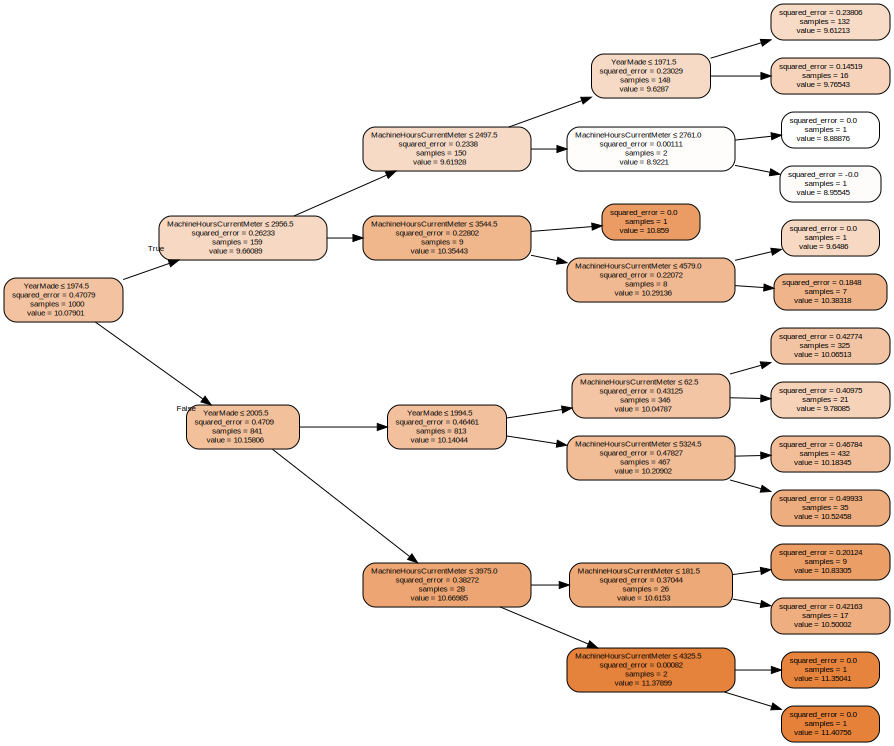

In [21]:
m = RandomForestRegressor(n_estimators=1, max_depth=4, bootstrap=False)
m.fit(x_sampJ, y_sampJ)
draw_tree(model = m, estimator=0, col_names=x_sampJ.columns, precision=5)#, col_names=X_train.columns, fontsize=8, precision=5);

In [22]:
# Look at a few nodes
ensJ.trees[0].rhs, ensJ.trees[0].rhs.rhs, ensJ.trees[0].rhs.rhs.rhs

(n: 841; val:10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade,
 n: 28; val:10.669849650935848; score:16.460871194578985; split:895.0; var:MachineHoursCurrentMeter,
 n: 15; val:10.822622840220621; score:6.965889973184171; split:1307.0; var:MachineHoursCurrentMeter)

If we compare the bottom branch to the node stats above, we can see everything looks groovy up until the third node where the results deviate.

Let's see if the same occurs with my model.

In [23]:
ensM2 = TreeEnsembleM2(x_sub, y_train, 1, sample_sz=1000)
treeM20 = ensM2.trees[0]
x_sampM2,y_sampM2 = treeM20.x, treeM20.y
x_sampM2.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [24]:
# Look at a few nodes
ensM2.trees[0].rhs, ensM2.trees[0].rhs.rhs, ensM2.trees[0].rhs.rhs.rhs

(n: 841; val:10.158064432982941; score:571.4803525045129; split:2005; var:YearMade,
 n: 28; val:10.669849650935848; score:16.460871194580115; split:895.0; var:MachineHoursCurrentMeter,
 n: 15; val:10.822622840220621; score:6.965889973184153; split:1307.0; var:MachineHoursCurrentMeter)

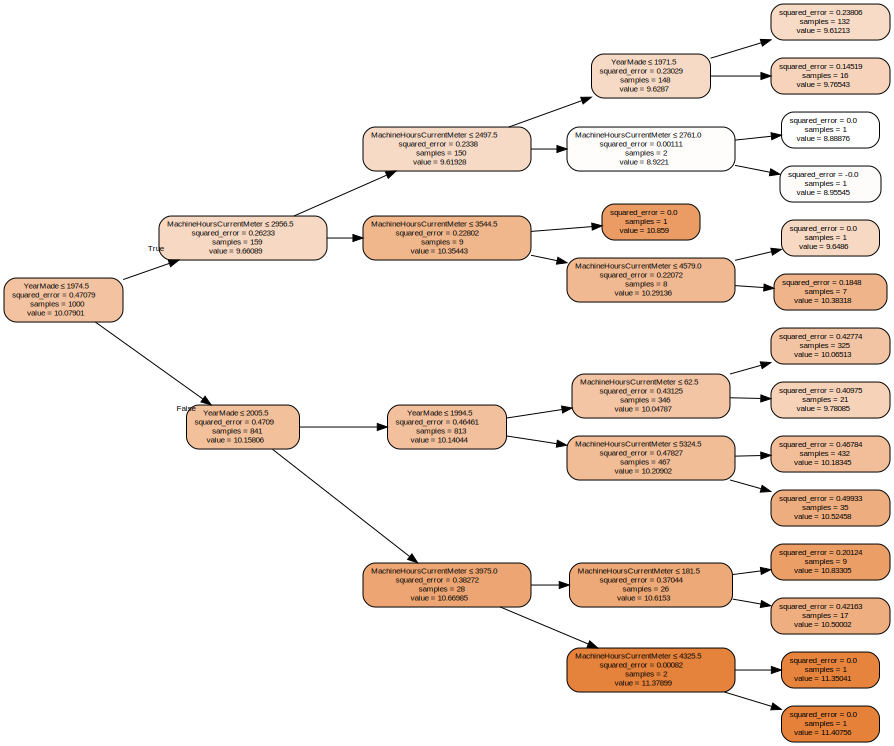

In [25]:
m = RandomForestRegressor(n_estimators=1, max_depth=4, bootstrap=False)
m.fit(x_sampM2, y_sampM2)
draw_tree(model = m, estimator=0, col_names=x_sampM2.columns, precision=5)#, col_names=X_train.columns, fontsize=8, precision=5);

We can see almost identical divergence when compared with Jeremy's model. This indicates that the outputs are pretty similar (and the differences between them can probably be put down to floating point representation).